# Lab 2: Cats vs Dogs
Zhiwei Qian 1002934346
**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1bw1vesWoNK8LZyW28gwPgxyQstQDcRQW#scrollTo=LfiFE_WOqIDu

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [8]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [9]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

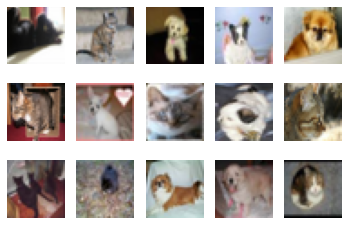

In [10]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [11]:
print("Number of training examples: ", len(train_loader))
print("Number of validation examples: ", len(val_loader))
print("Number of test examples: ", len(test_loader))

Number of training examples:  8000
Number of validation examples:  2000
Number of test examples:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

**A validation set is needed so that hyperparameters can be tuned to avoid overfitting on the training set. If the performance is judged using the training set loss/error, overfitting cannot be detected.**

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [12]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [13]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [14]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [20]:
#Total number of parameters in small_net
small_sum = 0
for para in small_net.parameters():
    print(para.shape)
    small_num = 1
    for i in range(len(para.shape)):
      small_num = para.shape[i] * small_num
    small_sum = small_sum + small_num
print("Total number of parameters in small_net: ",small_sum)

#Total number of parameters in large_net
large_sum = 0
for para in large_net.parameters():
    print(para.shape)
    large_num = 1
    for i in range(len(para.shape)):
      large_num = para.shape[i] * large_num
    large_sum = large_sum + large_num
print("Total number of parameters in large_net: ",large_sum)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
Total number of parameters in small_net:  386
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
Total number of parameters in large_net:  9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size, learning_rate, num_epochs, save_dir):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        path = F"{save_dir}/{model_path}"
        torch.save(net.state_dict(), model_path)
        # print(model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}/{}_train_err.csv".format(save_dir,model_path), train_err)
    np.savetxt("{}/{}_train_loss.csv".format(save_dir,model_path), train_loss)
    np.savetxt("{}/{}_val_err.csv".format(save_dir,model_path), val_err)
    np.savetxt("{}/{}_val_loss.csv".format(save_dir,model_path), val_loss)
    # print(model_path,"_train_err.csv")
    # print(model_path,"_train_loss.csv")
    # print(model_path,"_val_err.csv")
    # print(model_path,"_val_loss.csv")

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

 **The default value of ```batch_size``` is 64.
The default value of ```learning_rate``` is 0.01.
The default value of ```num_epochs``` is 30.**

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
small_net=SmallNet()
train_net(small_net, 64, 0.01, 5, "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part2c")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716783523559 |Validation err: 0.3865, Validation loss: 0.6602997500449419
Epoch 2: Train err: 0.37325, Train loss: 0.6497629323005676 |Validation err: 0.3845, Validation loss: 0.6575995869934559
Epoch 3: Train err: 0.359875, Train loss: 0.6388978385925292 |Validation err: 0.3495, Validation loss: 0.6291275043040514
Epoch 4: Train err: 0.346375, Train loss: 0.6246587996482849 |Validation err: 0.356, Validation loss: 0.6221408396959305
Epoch 5: Train err: 0.334375, Train loss: 0.6153830280303955 |Validation err: 0.3275, Validation loss: 0.6188967823982239
Finished Training
Total time elapsed: 18.81 seconds


**There are five model files which correspond to epochs 0 to 4:**

**model_small_bs64_lr0.01_epoch0**

**model_small_bs64_lr0.01_epoch1**

**model_small_bs64_lr0.01_epoch2**

**model_small_bs64_lr0.01_epoch3**

**model_small_bs64_lr0.01_epoch4**



**The other four .csv files with the following file names contain the information of the training loss and error after each epoch:**

**model_small_bs64_lr0.01_epoch4_train_err.csv**

**model_small_bs64_lr0.01_epoch4_train_loss.csv**

**model_small_bs64_lr0.01_epoch4_val_err.csv**

**model_small_bs64_lr0.01_epoch4_val_loss.csv**

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet()
train_net(small_net, 64, 0.01, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part2d_small")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42225, Train loss: 0.6727100286483765 |Validation err: 0.3765, Validation loss: 0.6569850891828537
Epoch 2: Train err: 0.36625, Train loss: 0.6448089990615845 |Validation err: 0.372, Validation loss: 0.6601140052080154
Epoch 3: Train err: 0.346375, Train loss: 0.6304390878677368 |Validation err: 0.3485, Validation loss: 0.6269233729690313
Epoch 4: Train err: 0.340625, Train loss: 0.6143888645172119 |Validation err: 0.3575, Validation loss: 0.629908038303256
Epoch 5: Train err: 0.32725, Train loss: 0.6039248919486999 |Validation err: 0.3245, Validation loss: 0.6112781278789043
Epoch 6: Train err: 0.30925, Train loss: 0.5919575576782227 |Validation err: 0.3195, Validation loss: 0.6119373049587011
Epoch 7: Train err: 0.310875, Train loss: 0.5856802501678466 |Validation err: 0.323, Validation loss: 0.6024169130250812
Epoch 8: Train err: 0.306125, Train loss: 0.5764534962177277 |Validation err:

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.01, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part2d_large")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203123092651 |Validation err: 0.4285, Validation loss: 0.6807542946189642
Epoch 2: Train err: 0.4195, Train loss: 0.67819615650177 |Validation err: 0.413, Validation loss: 0.6741204150021076
Epoch 3: Train err: 0.39875, Train loss: 0.6658886175155639 |Validation err: 0.3925, Validation loss: 0.6518177818506956
Epoch 4: Train err: 0.373875, Train loss: 0.6490470728874207 |Validation err: 0.406, Validation loss: 0.6635930277407169
Epoch 5: Train err: 0.35375, Train loss: 0.6330237889289856 |Validation err: 0.353, Validation loss: 0.6284337677061558
Epoch 6: Train err: 0.339125, Train loss: 0.6160062110424042 |Validation err: 0.34, Validation loss: 0.6150468923151493
Epoch 7: Train err: 0.32625, Train loss: 0.6001663441658021 |Validation err: 0.335, Validation loss: 0.6086486000567675
Epoch 8: Train err: 0.313875, Train loss: 0.5828366029262543 |Validation err: 0.3325

**Based on the results above, the large network took longer to train with a total elapsed time of 125.19 seconds compared to 111.04 seconds of the small network. This is because the large network contains a larger number of hidden nodes and more hidden layers.**

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

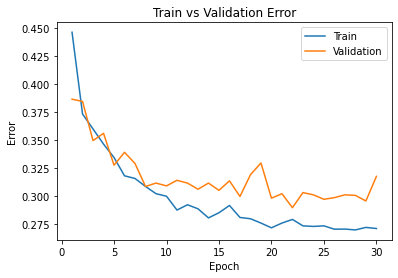

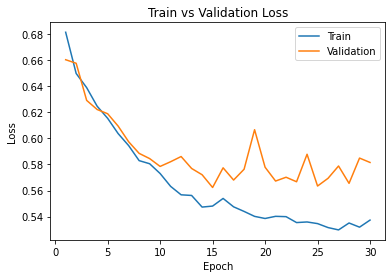

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
path_small = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part2d_small/{}".format(model_path)
plot_training_curve(path_small)

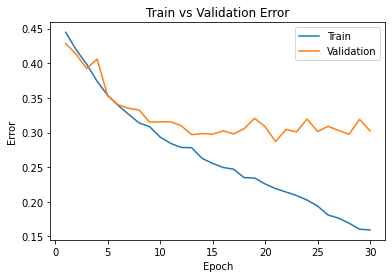

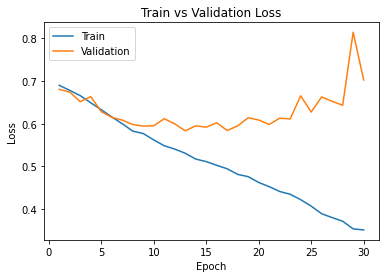

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part2d_large/{}".format(model_path)
plot_training_curve(path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Based on the training curve plotted above, it can be found that the slopes of the training loss and error decrease of large_net is steeper than the slopes of small_net. After 30 epochs, the validation error for large_net appears to be smaller than that of small_net. With regards to overfitting, large_net starts to overfit between around 10-15 epochs, while small_net doesn't experience overfitting in an obvious way. As a result, large_net has higher validation error and validation loss compared to small_net.**

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.500375, Train loss: 0.6928147830963135 |Validation err: 0.499, Validation loss: 0.6930030006915331
Epoch 2: Train err: 0.495375, Train loss: 0.691903844833374 |Validation err: 0.4785, Validation loss: 0.6919409688562155
Epoch 3: Train err: 0.486625, Train loss: 0.6910150880813599 |Validation err: 0.4665, Validation loss: 0.691474886611104
Epoch 4: Train err: 0.476625, Train loss: 0.6901541333198548 |Validation err: 0.4645, Validation loss: 0.6900496855378151
Epoch 5: Train err: 0.459875, Train loss: 0.6892932758331299 |Validation err: 0.461, Validation loss: 0.6899100057780743
Epoch 6: Train err: 0.45675, Train loss: 0.6884526004791259 |Validation err: 0.4575, Validation loss: 0.6892403606325388
Epoch 7: Train err: 0.448625, Train loss: 0.6876922945976257 |Validation err: 0.4565, Validation loss: 0.6887964513152838
Epoch 8: Train err: 0.45075, Train loss: 0.6868058938980103 |Validation err

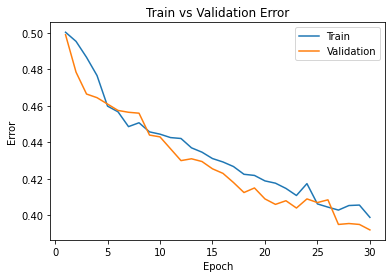

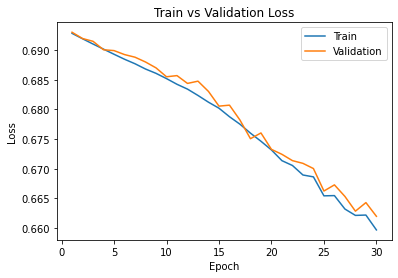

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3/{}".format(model_path)
plot_training_curve(path_large)

**Comparing the output result to the result in Part2e, when the learning rate is decreased to 0.001, the model takes a slightly longer time to train with a total elapsed time of 127.50 seconds compared to 125.19 seconds when learning rate is 0.01. As shown in the graphs, after lowering the learning rate, the validation curves fit the training curves better with no sign of overfitting.**

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

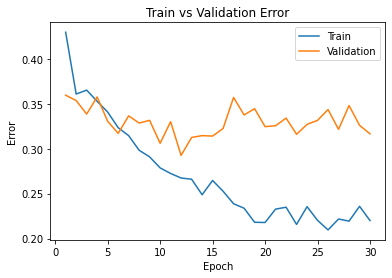

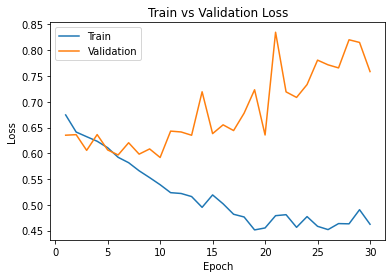

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3/{}".format(model_path)
plot_training_curve(path_large)

**When the learning rate is increased to 0.1, the model takes a slightly longer training time of 125.29 seconds, compared to 125.19 seconds when the learning rate is 0.01. As shown in the graphs above, an increased learning rate performs worse with regards to the results of validation error and loss, with the deviation from the training curves larger than the one from learning rates of 0.01 and 0.001. The model with a learning rate of 0.1 has higher training loss and error compared to the one with the default learning rate of 0.01, and a lower training loss and error compared to the one with a learning rate of 0.001.**

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379589855671 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130364656448
Epoch 4: Train err: 0.433625, Train loss: 0.6908450126647949 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434, Train loss: 0.6896936185657978 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883535124361515 |Validation err: 0.4285, Validation loss: 0.6860134303569794
Epoch 7: Train err: 0.43925, Train loss: 0.6866881102323532 |Validation err: 0.426, Validation loss: 0.6836976855993271
Epoch 8: Train err: 0.43525, Train loss: 0.6849788911640644 |Validation err: 0.412, 

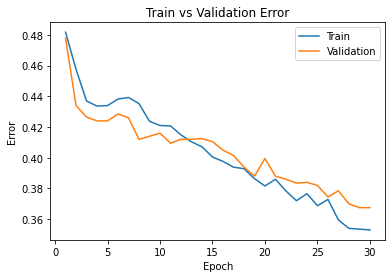

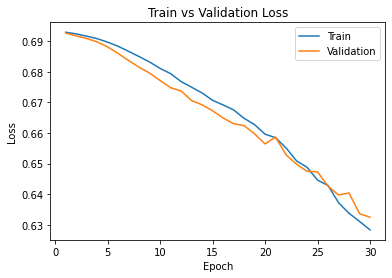

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3/{}".format(model_path)
plot_training_curve(path_large)

**When the batch size increases with all the other parameters remains the same as default, the model takes a significantly lower time to train with a total elapsed time of 107.92 seconds. This is due to the decreased number of batches with an increased batch size. The validation loss and error is similar to the ones when learning rate is decreased to 0.001 while other parameters remain unchanged. There is no sign of overfitting in the graphs.**

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part4b")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

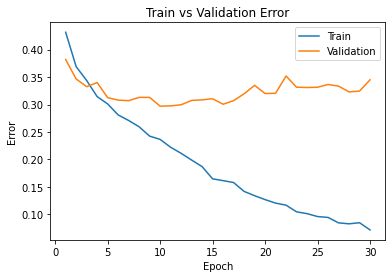

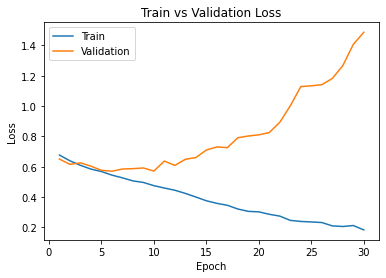

In [ ]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part3/{}".format(model_path)
plot_training_curve(path_large)

**When other default parameters remain unchanged while batch size is decreased to 16, the model takes the longest time to train with a total elapsed time of 176.27 seconds. From the plotted graphs above, the training loss and error appear to be the lowest with values of around 0.07 and 0.18 respectively. However, the gap between the training and validation errors and losses are the most significant. Particularly in the train vs validation loss graph, the validation loss curve starts to diverge after 5 epochs.**

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**From the plots above, I discover that a model with the default hyperparameters achieves the highest training accuracy, while a larger batch size contributes to a shorter elapsed time while avoiding overfitting. Therefore, I decide to use the larger network, with a batch size of 1024 and a learning rate of 0.08 to train the model so that the validation accuracy can be improved.**

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 1024, 0.08, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part4b")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47525, Train loss: 0.6927351504564285 |Validation err: 0.4335, Validation loss: 0.6919057369232178
Epoch 2: Train err: 0.458125, Train loss: 0.6913511082530022 |Validation err: 0.45, Validation loss: 0.6889449954032898
Epoch 3: Train err: 0.44075, Train loss: 0.6883475333452225 |Validation err: 0.426, Validation loss: 0.6837866306304932
Epoch 4: Train err: 0.43125, Train loss: 0.6839138641953468 |Validation err: 0.4165, Validation loss: 0.6768621504306793
Epoch 5: Train err: 0.41925, Train loss: 0.6783766821026802 |Validation err: 0.414, Validation loss: 0.6720985770225525
Epoch 6: Train err: 0.408, Train loss: 0.6719729155302048 |Validation err: 0.4115, Validation loss: 0.6659412682056427
Epoch 7: Train err: 0.396875, Train loss: 0.6666015908122063 |Validation err: 0.3975, Validation loss: 0.6600455939769745
Epoch 8: Train err: 0.3855, Train loss: 0.6587530374526978 |Validation err: 0.38,

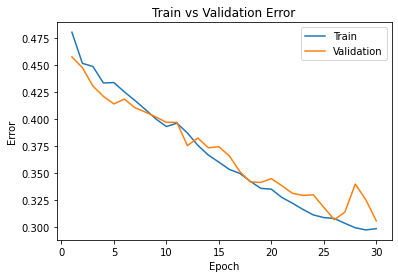

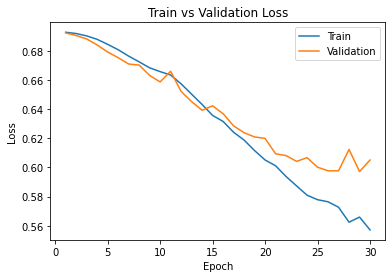

In [ ]:
model_path = get_model_name("large", batch_size=1024, learning_rate=0.05, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part4b/{}".format(model_path)
plot_training_curve(path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

**Based on the output graphs from Part(a), it is discovered that despite a better performance, overfitting still occurs starting from epoch 20 which leads to larger gap between training and validation losses and errors. To enhance the performance while avoiding overfitting, I decide to decrease the learning rate to 0.05.**

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 1024, 0.05, 30,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part4d")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48025, Train loss: 0.692861519753933 |Validation err: 0.4575, Validation loss: 0.6923681497573853
Epoch 2: Train err: 0.4515, Train loss: 0.6919781863689423 |Validation err: 0.4475, Validation loss: 0.690619170665741
Epoch 3: Train err: 0.448625, Train loss: 0.6903635263442993 |Validation err: 0.4305, Validation loss: 0.6882481575012207
Epoch 4: Train err: 0.433375, Train loss: 0.6879977062344551 |Validation err: 0.421, Validation loss: 0.6841238141059875
Epoch 5: Train err: 0.43375, Train loss: 0.6845527961850166 |Validation err: 0.414, Validation loss: 0.6792883276939392
Epoch 6: Train err: 0.425125, Train loss: 0.6808486878871918 |Validation err: 0.4185, Validation loss: 0.6754190325737
Epoch 7: Train err: 0.41725, Train loss: 0.6764698624610901 |Validation err: 0.4105, Validation loss: 0.6710297763347626
Epoch 8: Train err: 0.408875, Train loss: 0.6725167036056519 |Validation err: 0.40

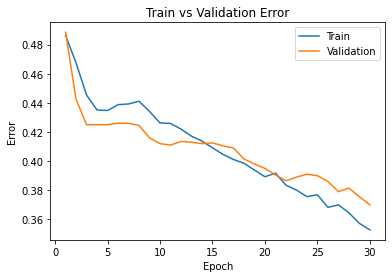

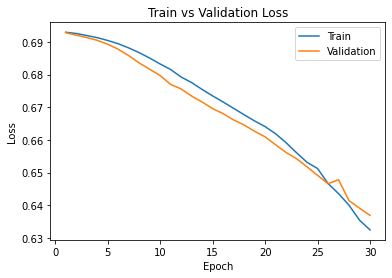

In [ ]:
model_path = get_model_name("large", batch_size=1024, learning_rate=0.02, epoch=29)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part4d/{}".format(model_path)
plot_training_curve(path_large)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
train_net(large_net,64,0.01,20,"/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part5")
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=19)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.450875, Train loss: 0.6895327234268188 |Validation err: 0.413, Validation loss: 0.6777133401483297
Epoch 2: Train err: 0.4125, Train loss: 0.6718954229354859 |Validation err: 0.4125, Validation loss: 0.6744592245668173
Epoch 3: Train err: 0.377875, Train loss: 0.6502781982421875 |Validation err: 0.3515, Validation loss: 0.6317496318370104
Epoch 4: Train err: 0.357125, Train loss: 0.6338643341064453 |Validation err: 0.346, Validation loss: 0.6284743025898933
Epoch 5: Train err: 0.344, Train loss: 0.623236093044281 |Validation err: 0.339, Validation loss: 0.6225271243602037
Epoch 6: Train err: 0.333875, Train loss: 0.613299825668335 |Validation err: 0.3265, Validation loss: 0.6152509264647961
Epoch 7: Train err: 0.329375, Train loss: 0.6050759675502777 |Validation err: 0.336, Validation loss: 0.6056180037558079
Epoch 8: Train err: 0.31575, Train loss: 0.5885010676383973 |Validation err: 0.32

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

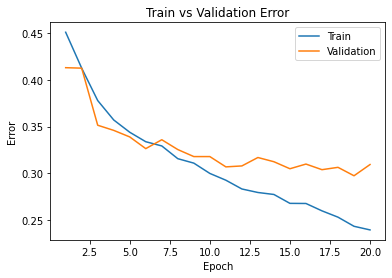

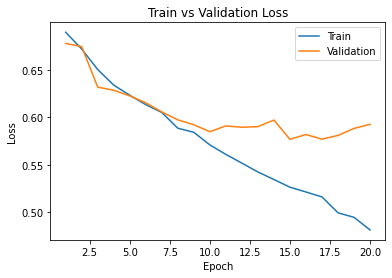

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=19)
path_large = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part5/{}".format(model_path)
plot_training_curve(path_large)

**Based on the results, the validation error and loss for the model are 0.3095 and 0.5926 respectively, which are the lowest overall compared to other models.**

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("Test classification error: {}, Test loss: {}".format(test_err,test_loss))

Test classification error: 0.285, Test loss: 0.5820299563929439


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**The test error is lower than the validation error. Test error should be expected to be higher than the validation error because because the model hyperparameters are tuned based on the performance of the validation dataset.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**The reason that test data set was only used at the very end is that otherwise the model will improve its performance based on the results of the test data, which does not achieve the purpose of the training.**

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
#define a 2-layer ANN
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(3 * 32 * 32, 50)
        self.layer2 = nn.Linear(50, 1)

    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)

        return activation2

In [ ]:
def train_ann(net, batch_size, learning_rate, num_epochs):
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        # print(("Epoch {}: Train err: {}, Train loss: {} |"+
        #        "Validation err: {}, Validation loss: {}").format(
        #            epoch + 1,
        #            train_err[epoch],
        #            train_loss[epoch],
        #            val_err[epoch],
        #            val_loss[epoch]))
        # # Save the current model (checkpoint) to a file
        # model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        # path = F"{save_dir}/{model_path}"
        # torch.save(net.state_dict(), path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    print("Train Error:", train_err[-1])
    print("Train Loss:", train_loss[-1])
    print("Validation Error:", val_err[-1])
    print("Validation Loss:", val_loss[-1])
    model_path = get_model_name("ann",batch_size, learning_rate, epoch)
    path = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part5/{}".format(model_path)
    torch.save(net.state_dict(), path)
    return train_err, train_loss, val_err, val_loss

**The ANN model is tested by tuning different hyperparameters as illustrated below.**

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 96.72 seconds
Train Error: 0.333
Train Loss: 0.6548325877189636
Validation Error: 0.422
Validation Loss: 0.9371379688382149


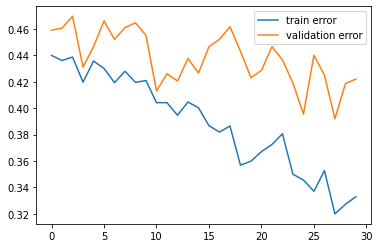

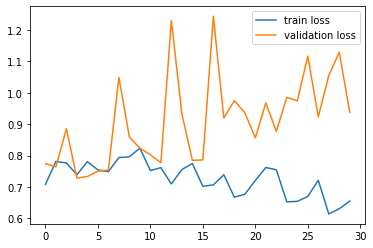

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 64, 0.1, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 95.15 seconds
Train Error: 0.08675
Train Loss: 0.2228291545510292
Validation Error: 0.3765
Validation Loss: 1.1647865008562803


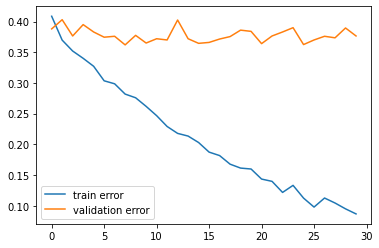

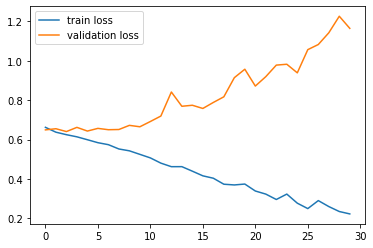

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 64, 0.01, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 94.88 seconds
Train Error: 0.266125
Train Loss: 0.5434378244876862
Validation Error: 0.362
Validation Loss: 0.6371274851262569


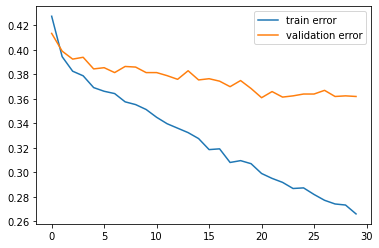

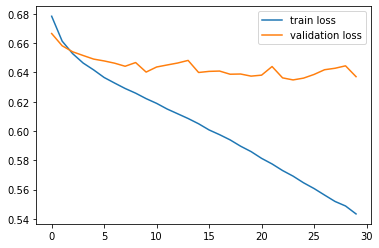

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 64, 0.001, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 80.57 seconds
Train Error: 0.241625
Train Loss: 0.5066345278173685
Validation Error: 0.375
Validation Loss: 0.6558107733726501


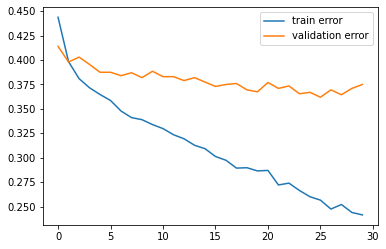

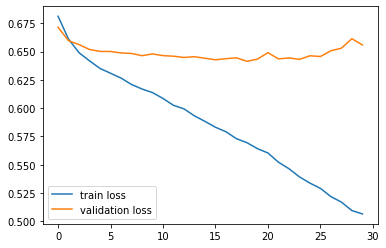

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 512, 0.01, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 80.99 seconds
Train Error: 0.37225
Train Loss: 0.6424715630710125
Validation Error: 0.3875
Validation Loss: 0.6519205123186111


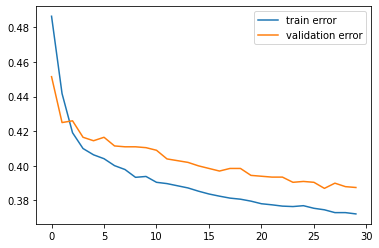

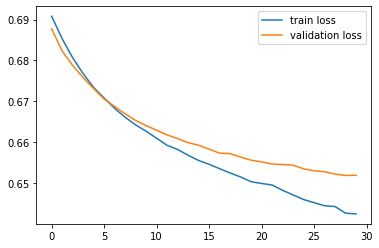

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 512, 0.001, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 82.18 seconds
Train Error: 0.30725
Train Loss: 0.5899818316102028
Validation Error: 0.3775
Validation Loss: 0.6414815485477448


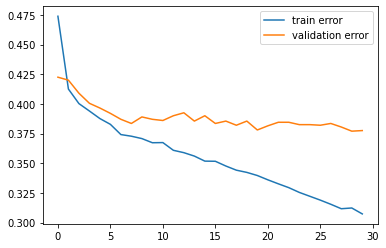

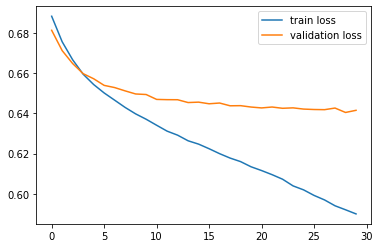

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 1024, 0.01, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified
Finished Training
Total time elapsed: 81.19 seconds
Train Error: 0.16875
Train Loss: 0.39788035303354263
Validation Error: 0.3605
Validation Loss: 0.7342514097690582


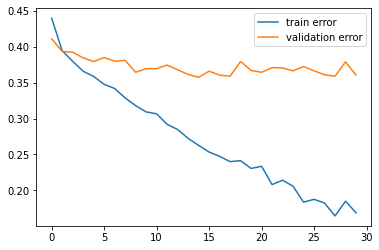

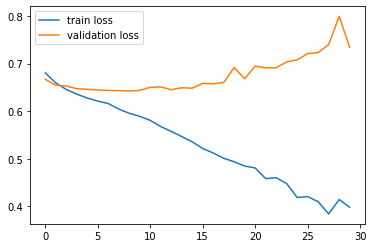

In [ ]:
ann = ANN()
train_err, train_loss, val_err, val_loss = train_ann(ann, 1024, 0.05, 30)

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_err, label='train error')
plt.plot(t,val_err,label='validation error')
plt.legend()

t = np.transpose(np.arange(0,30,1))
plt.figure()
plt.plot(t,train_loss, label='train loss')
plt.plot(t,val_loss,label='validation loss')
plt.legend()

In [ ]:
#The best result of the ANN model across all the above parameters
net = ANN()
model_path = get_model_name("ann", batch_size=64, learning_rate=0.001, epoch=29)
path = "/content/gdrive/My Drive/Colab Notebooks/APS360_labs/Lab2_Part5/{}".format(model_path)
state = torch.load(path)
net.load_state_dict(state)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("Test error: {}, Test loss: {}".format(test_err,test_loss))

Files already downloaded and verified
Files already downloaded and verified
Test error: 0.358, Test loss: 0.6396825276315212


**When the batch size is 64, the learning rate is 0.001 and the epoch number is set to 30, the ANN model produces the best result with test error of 0.358 and test loss of around 0.640. Based on the results, the ANN model does not perform as well as the CNN model since it has a higher chance of overfitting due to its fully connected layers.**

In [19]:
%%shell
jupyter nbconvert --to html /content/APS360_Lab2_Zhiwei_Qian_1002934346.ipynb

[NbConvertApp] Converting notebook /content/APS360_Lab2_Zhiwei_Qian_1002934346.ipynb to html
[NbConvertApp] Writing 1295032 bytes to /content/APS360_Lab2_Zhiwei_Qian_1002934346.html
